# Kaggle Home Credit Competition
Student Names:
- WANG Ziyi (20256265)
- XIANG Jixiang (20568852)

# 1. Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [43]:
# Read and merge data
df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')

print("Train data: {}, test data: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
# df.head()

Train data: 307511, test data: 48744


## Remove specific noise

In [44]:
# Defining Sin-cos transformation for cyclic features
def encode(df, col, max_val):
    df[col + '_SIN'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_COS'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# Defining one-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [45]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Changing rare categories of NAME_INCOME_TYPE with the similar categories
df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'State servant'
df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'

# Rare Encoding NAME_HOUSING_TYPE with 'Other'
df.loc[(df['NAME_HOUSING_TYPE'] == 'Office apartment') &
       (df['NAME_HOUSING_TYPE'] == 'Co-op apartment'), 'NAME_HOUSING_TYPE'] = 'Other'

#  Changing unknown family status with the most observed category
df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)

#  Changing HOUSETYPE_MODE not null values with
df.loc[df['HOUSETYPE_MODE'].notnull(), 'HOUSETYPE_MODE'] = 'house_type_reported'

# Changing weekdays with integer values
weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)

# Creating sin-cos transformed features
df = encode(df, 'WEEKDAY_APPR_PROCESS_START', 7)
df = encode(df, 'HOUR_APPR_PROCESS_START', 23)

# Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
df.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

## Add additional features

In [46]:
# new feature revolving loans
df['NEW_REVOLVING_LOANS']=1 
df.loc[(df['NAME_CONTRACT_TYPE']!='Revolving loans'),'NEW_REVOLVING_LOANS']=0
df['NEW_REVOLVING_LOANS'] = df['NEW_REVOLVING_LOANS'].astype(object)

# new feature has car
df['NEW_HAS_CAR']=1 
df.loc[(df['FLAG_OWN_CAR']!='Y'),'NEW_HAS_CAR']=0
df['NEW_HAS_CAR'] = df['NEW_HAS_CAR'].astype(object)

# new feature has rent
df['NEW_RENT_EXPENSE']=1 
df.loc[(df['FLAG_OWN_REALTY']!='Y'),'NEW_RENT_EXPENSE']=0
df['NEW_RENT_EXPENSE'] = df['NEW_RENT_EXPENSE'].astype(object)

# new feature has company
df['NEW_HAS_COMPANY']=1 
df.loc[(df['NAME_INCOME_TYPE']!='Commercial associate'),'NEW_HAS_COMPANY']=0
df['NEW_HAS_COMPANY'] = df['NEW_HAS_COMPANY'].astype(object)

df['NEW_LABORERS']=0 
df.loc[(df["OCCUPATION_TYPE"] == "Cleaning staff") | (df["OCCUPATION_TYPE"] == "Cooking staff") | 
       (df["OCCUPATION_TYPE"] == "Drivers") | (df["OCCUPATION_TYPE"] == "Laborers")
      | (df["OCCUPATION_TYPE"] == "Low-skill Laborers") | (df["OCCUPATION_TYPE"] == "Sales staff")
      | (df["OCCUPATION_TYPE"] == "Security staff") | (df["OCCUPATION_TYPE"] == "Waiters/barmen staff"), 'NEW_LABORERS' ] = 1
df['NEW_LABORERS'] = df['NEW_LABORERS'].astype(object)

# New features (percentages)
df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['NEW_ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Mean of External Sources
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Product of External Sources
df['NEW_EXT_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Ages of customers
df['NEW_AGE'] = df['DAYS_BIRTH'] / -365

# NEW_AGE_SEGMENT segments
df.loc[df['NEW_AGE'] <= 34, 'NEW_AGE_SEGMENT'] = 'YOUNG'
df.loc[(df['NEW_AGE'] > 34) & (df['NEW_AGE'] <= 54), 'NEW_AGE_SEGMENT'] = 'MİDDLE'
df.loc[df['NEW_AGE'] > 54, 'NEW_AGE_SEGMENT'] = 'OLD'

# NEW_ACCOMPANIED feature
df.loc[df['NAME_TYPE_SUITE'] == 'Unaccompanied', 'NEW_ACCOMPANIED'] = 0
df.loc[df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NEW_ACCOMPANIED'] = 1
df.loc[df['NAME_TYPE_SUITE'].isnull(), 'NEW_ACCOMPANIED'] = np.nan

# Social circle with both 30 and 60 days default (binary)
df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
       'NEW_DEF_30&60_SOCIAL_CIRCLE'] = 1
df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
       'NEW_DEF_30&60_SOCIAL_CIRCLE'] = 0

# Label encoding
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])

# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df)

# Dropping feature named index
df.drop('index', axis=1, inplace=True)

In [47]:
df.shape

(356255, 272)

## Handle Missing Value

In [48]:
def missing_values_table(df):
    # total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    # rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # sort the table by percentage of missing decending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% of Total Values', ascending = False).round(1)
    
    # print some summary information
    print('your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
          'there are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values')
    
    # return the dataframe with missing information
    return mis_val_table_ren_columns

In [49]:
missing_train = missing_values_table(df)
missing_train.head(10)

your selected dataframe has 272 columns.
there are 71 columns that have missing values


,Missing Values,% of Total Values
COMMONAREA_MEDI,248360,69.7
COMMONAREA_MODE,248360,69.7
COMMONAREA_AVG,248360,69.7
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
NONLIVINGAPARTMENTS_MEDI,246861,69.3
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2
LIVINGAPARTMENTS_MODE,242979,68.2
FLOORSMIN_MEDI,241108,67.7


In [50]:
# We removed those columns with > 80% missing values
missing_columns = list(missing_train.index[missing_train['% of Total Values'] > 80])
len(missing_columns)

0

In [51]:
df = df.drop(columns = missing_columns)

## Check Numeric Columns

In [52]:
corrs = df.corr()

corrs = corrs.sort_values('TARGET', ascending = False)

# ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
NEW_LABORERS_1.0,0.075516
DAYS_EMPLOYED,0.074958
NEW_AGE_SEGMENT_YOUNG,0.061939
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
NAME_INCOME_TYPE_Working,0.057481
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457


In [53]:
# remove highly correlated columns

# set the threshold
threshold = 0.8

# empty dictionary to hold correlated variables
above_threshold_vars = {}

# for each columns, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
# track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
cols_to_remove = list(set(cols_to_remove))
print('number of columns to remove: ', len(cols_to_remove))

number of columns to remove:  52


In [24]:
df = df.drop(columns = cols_to_remove)

In [25]:
df.shape

(356255, 83)

In [26]:
df.to_csv('features.csv')

# Model Training

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [5]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

# Show the feature importances for the default features
# feature_importances_sorted = plot_feature_importances(feature_importances)

In [6]:
df = pd.read_csv('features.csv')
df = df.dropna(subset = ['TARGET']) 
print(df.shape)
df.fillna(df.mean(), inplace=True)

(307511, 221)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
        df[df.columns[~df.columns.isin(['TARGET','Unnamed: 0', 'SK_ID_CURR'])]],
        df['TARGET'], test_size=0.33, random_state=42)

In [8]:
X_train.shape

(206032, 218)

In [9]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(X_train, y_train)

# Extract feature importances
features = list(X_train.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


In [10]:
y_pred = [1 if i >= 0.5 else 0 for i in predictions]
print (accuracy_score(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

0.9201214044285024
[[93346    16]
 [ 8090    27]]


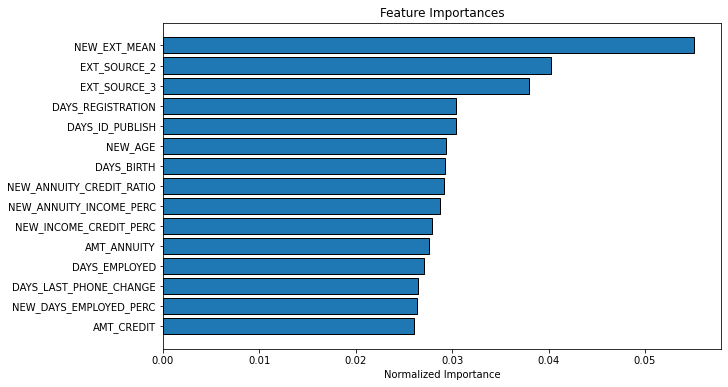

In [11]:
# get the explainability of features
feature_importances_sorted = plot_feature_importances(feature_importances)
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()

# Build Model with only top 10 important features

In [12]:
df_features = feature_importances['feature'].head(10)

In [13]:
# Train on the training data
random_forest.fit(X_train[df_features], y_train)

# Make predictions on the test data
predictions2 = random_forest.predict_proba(X_test[df_features])[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


In [14]:
y_pred2 = [1 if i >= 0.5 else 0 for i in predictions2]
print (accuracy_score(y_test, y_pred2))
print (confusion_matrix(y_test, y_pred2))

0.9195695661171277
[[93189   173]
 [ 7989   128]]


# Use SMOTE or Under Sampling to deal with Imbalance

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train[df_features], y_train)

In [16]:
X_res.shape

(378648, 10)

In [17]:
from imblearn.under_sampling import RandomUnderSampler
um = RandomUnderSampler(sampling_strategy='all')
X_under, y_under = um.fit_resample(X_train[df_features], y_train)

In [18]:
X_under.shape

(33416, 10)

In [19]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(X_res, y_res)

# Extract feature importances
features = list(X_res.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_test[df_features])[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


In [20]:
y_pred = [1 if i >= 0.5 else 0 for i in predictions]
print (accuracy_score(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

0.7996826929709595
[[78405 14957]
 [ 5371  2746]]


In [21]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(X_under, y_under)

# Extract feature importances
features = list(X_under.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions_under = random_forest.predict_proba(X_test[df_features])[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [22]:
y_pred_under = [1 if i >= 0.5 else 0 for i in predictions_under]
print (accuracy_score(y_test, y_pred_under))
print (confusion_matrix(y_test, y_pred_under))

0.6672119354743345
[[62351 31011]
 [ 2760  5357]]
